In [1]:
import os
import rasterio
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from earthpy.spatial import normalized_diff

In [2]:
from numpy import asarray
import numpy as np

import os
import cv2
import glob
# import imagehash
from PIL import Image

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ignore the deprecated warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# Specify the directories containing the masks and the original images
masks_directory = r'E:\Final\clipped_tiles_ndvi_data'
originals_directory = r'E:\Final\clipped_tiles_sat_data'

In [4]:
# Initialize lists to store the images and masks
X = []
y = []

# Check each file in the original images folder
for file in os.listdir(originals_directory):
    # If the file has a corresponding mask, add the image and mask to the lists
    if file in os.listdir(masks_directory):
        with rasterio.open(os.path.join(originals_directory, file)) as src:
            green_band = src.read(1)
            red_band = src.read(2)
            nir_band = src.read(3)
            swir_band = src.read(4)
        
            image_data = np.dstack(src.read([3, 2, 1]))  # Read the bands into a 3D array (NIR, Red, Green)
        
            # Normalize the composite image to the range 0-1
            image_data = image_data / np.max(image_data)
            
        with rasterio.open(os.path.join(masks_directory, file)) as src:
            mask = src.read(1)  # Assuming the mask is a single-band image
        
        X.append(image_data)
        y.append(mask)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("Images and masks added to arrays.")


Images and masks added to arrays.


In [5]:
print(X.shape)
print(y.shape)

(1004, 256, 256, 3)
(1004, 256, 256)


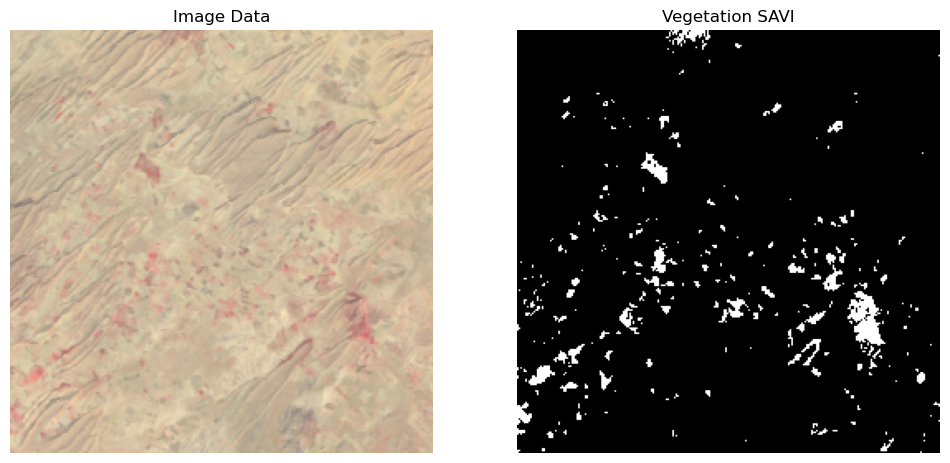

In [6]:
import matplotlib.pyplot as plt

# Select the first data point
image_data = X[528]
vegetation_savi = y[528]

# Plot the image data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data)
plt.title('Image Data')
plt.axis('off')

# Plot the vegetation SAVI
plt.subplot(1, 2, 2)
plt.imshow(vegetation_savi, cmap='gray')
plt.title('Vegetation SAVI')
plt.axis('off')

plt.show()


In [7]:
unique_labels = np.unique(y)
print(unique_labels)

[0 1]


In [8]:
# Assuming y is your original array with shape (1004, 256, 256)
y_expanded = np.expand_dims(y, axis=-1)

print(y_expanded.shape)  # Prints: (1004, 256, 256, 1)

(1004, 256, 256, 1)


In [9]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_expanded, test_size=0.25, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (602, 256, 256, 3)
y_train shape: (602, 256, 256, 1)
X_val shape: (151, 256, 256, 3)
y_val shape: (151, 256, 256, 1)
X_test shape: (251, 256, 256, 3)
y_test shape: (251, 256, 256, 1)


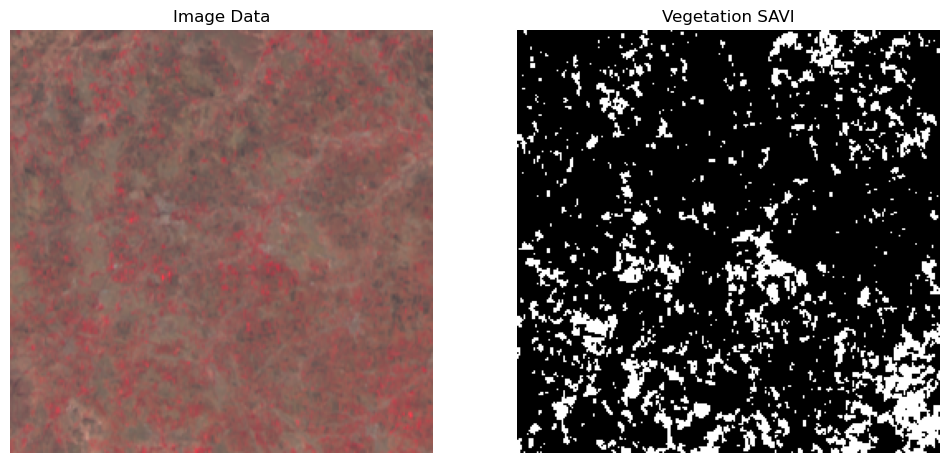

In [10]:
import matplotlib.pyplot as plt

# Select the first data point
image_data = X_val[52]
vegetation_savi = y_val[52]

# Plot the image data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data)
plt.title('Image Data')
plt.axis('off')

# Plot the vegetation SAVI
plt.subplot(1, 2, 2)
plt.imshow(vegetation_savi, cmap='gray')
plt.title('Vegetation SAVI')
plt.axis('off')

plt.show()


In [11]:
# Define a callback for early stopping if the validation loss does not improve for 5 consecutive
# epochs (patience=3).
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [12]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
# from keras.optimizers import Adam
# import keras.backend as K

# def dice_coefficient(y_true, y_pred):
#     y_true = tf.cast(y_true, dtype=tf.float32)
#     y_pred = tf.cast(y_pred, dtype=tf.float32)

#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     return (2.0 * intersection + 1e-5) / (union + 1e-5)

# def dice_loss(y_true, y_pred):
#     return 1 - dice_coefficient(y_true, y_pred)

In [13]:
# Import the necessary modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the unet model
def unet_model(input_shape=(256, 256, 3), num_classes=1):
  # Define the input layer
  inputs = keras.Input(shape=input_shape)

  # Define the encoder blocks
  # Each block consists of two convolutional layers followed by a max pooling layer
  # The number of filters is doubled after each block
  conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
  conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
  pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
  conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
  pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
  conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)
  pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(pool3)
  conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv4)
  pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

  # Define the bottleneck layer
  # This is the lowest resolution layer in the encoder
  conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(pool4)
  conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(conv5)

  # Define the decoder blocks
  # Each block consists of an up-convolutional layer followed by a concatenation with the corresponding encoder feature map, and two convolutional layers
  # The number of filters is halved after each block
  up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(conv5)
  up6 = layers.concatenate([up6, conv4], axis=3)
  conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(up6)
  conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv6)

  up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(conv6)
  up7 = layers.concatenate([up7, conv3], axis=3)
  conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(up7)
  conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv7)

  up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(conv7)
  up8 = layers.concatenate([up8, conv2], axis=3)
  conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(up8)
  conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv8)

  up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(conv8)
  up9 = layers.concatenate([up9, conv1], axis=3)
  conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(up9)
  conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv9)

  # Define the output layer
  # Use a 1x1 convolution with sigmoid activation for binary segmentation
  outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(conv9)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Return the model
  return model

# Create the unet model
model = unet_model()


In [14]:
# Compile the model with binary_crossentropy as loss function
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with augmented data
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=15)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test dice coefficient:', score[1])


Epoch 1/15


19/19 [==============================] - 2295s 120s/step - loss: 0.5940 - accuracy: 0.7693 - val_loss: 0.4108 - val_accuracy: 0.7960
Epoch 2/15
19/19 [==============================] - 2263s 119s/step - loss: 0.3516 - accuracy: 0.8239 - val_loss: 0.2972 - val_accuracy: 0.8843
Epoch 3/15
19/19 [==============================] - 2259s 119s/step - loss: 0.2725 - accuracy: 0.8930 - val_loss: 0.2521 - val_accuracy: 0.8931
Epoch 4/15
19/19 [==============================] - 2263s 119s/step - loss: 0.2371 - accuracy: 0.9036 - val_loss: 0.2422 - val_accuracy: 0.8939
Epoch 5/15
19/19 [==============================] - 2265s 119s/step - loss: 0.2204 - accuracy: 0.9084 - val_loss: 0.2446 - val_accuracy: 0.8937
Epoch 6/15
19/19 [==============================] - 2261s 119s/step - loss: 0.2223 - accuracy: 0.9074 - val_loss: 0.2271 - val_accuracy: 0.8986
Epoch 7/15
19/19 [==============================] - 2264s 119s/step - loss: 0.2055 - accuracy: 0.9166 - val_loss: 0.2090 - val_accura

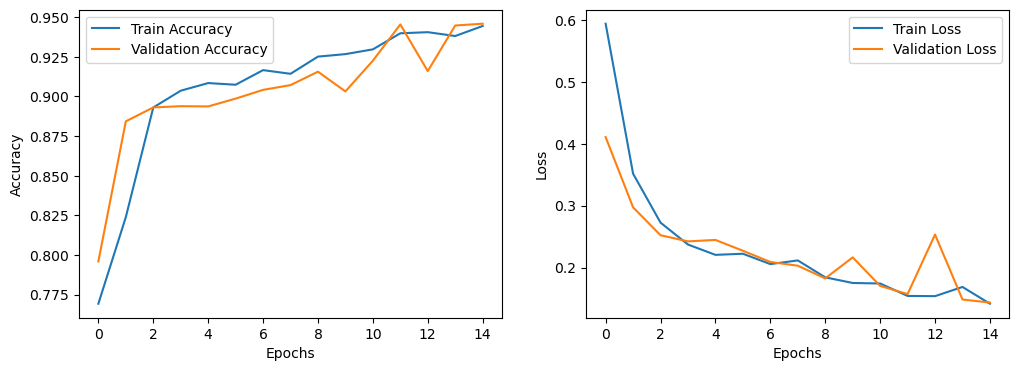

In [15]:
# Assuming 'history' is the output of the 'fit' method
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


5/5 [==============================] - 110s 21s/step


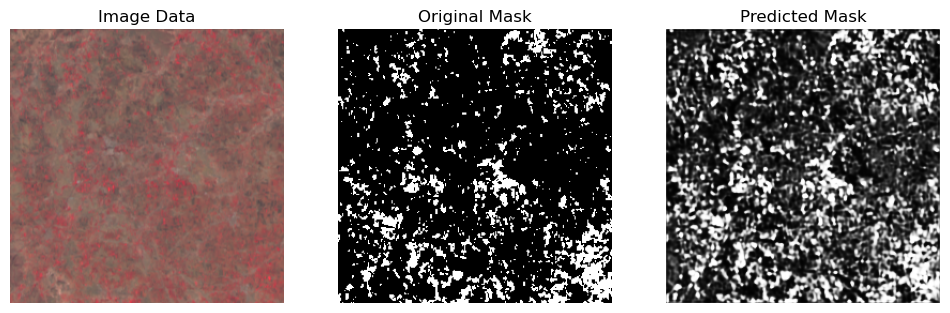

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model is already trained and stored in 'model'

# Predict on the validation set
y_pred = model.predict(X_val)

# # Choose a random sample index from the validation set
# sample_index = np.random.randint(0, len(X_val))

import matplotlib.pyplot as plt

# Select the first data point
image_data = X_val[52]
vegetation_savi = y_val[52]

# Plot the image data
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_data)
plt.title('Image Data')
plt.axis('off')

# Plot the vegetation SAVI
plt.subplot(1, 3, 2)
plt.imshow(y_val[52], cmap='gray')
plt.title('Original Mask')
plt.axis('off')

# Plot the vegetation SAVI
plt.subplot(1, 3, 3)
plt.imshow(y_pred[52], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()



In [17]:
# Save the model
model.save("unet_model_2.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
